## 1. Prepare Environment

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.envfiles/dev.env")

True

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline # type:ignore
from src.db import OptoFile
from src.spectra import Sample


subjects = ['s1', 's2', 's3', 's4', 's5', 
            's6', 's7', 's8', 's9', 's10', 
            's11', 's12', 's13', 's14', 's15']

In [25]:
from matplotlib import colors
import seaborn as sns

## 2. Check data

In [ ]:
# fig, ax = plt.subplots(figsize=(16,9))
# color_list = list(colors.TABLEAU_COLORS.values())

# for index, (subj_id, data) in enumerate(zip(subj_ids, datas)):
#     y = data.glucose
#     x = y.index
#     y = y.interpolate(method='polynomial', order=2)
#     glucoses += list(y)
#     elapse = x - x[1]
#     ax.scatter(elapse + today, y, c=color_list[index], marker='.')
#     ax.scatter(elapse + today, data.glucose, c=color_list[index])
#     ax.plot(elapse + today, y, label=subj_id, color=color_list[index])
#     # Update the interpolated data
#     data.glucose = y

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# ax.scatter(0,0, marker='o', label='collected data', c='black')
# ax.scatter(0,0, marker='.', label='interpolated data', c='black')
# # ax.set_title("A result of OGTT of 8 participants with polynomial interpolation")
# ax.set_xlabel("Elapsed time")
# ax.set_ylabel("Glycemic (mg/dL)")
# axisx_format = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_formatter(axisx_format)
# ax.axhspan(60,70, color='grey', alpha=0.1)
# ax.axhspan(70,90, color='orange', alpha=0.1)
# ax.axhspan(90,160, color='green', alpha=0.1)
# ax.axhspan(160,180, color='orange', alpha=0.1)
# ax.axhspan(180,250, color='red', alpha=0.1)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.legend()
# ax.grid()
# plt.show()

In [4]:
dataset = [df for df in [await load_subject(subject_id=subject_id) for subject_id in subjects]]

Loaded subject s1 with 25 samples, of which 25 have glucose_target values.
Loaded subject s2 with 26 samples, of which 10 have glucose_target values.
Loaded subject s3 with 30 samples, of which 12 have glucose_target values.
Loaded subject s4 with 32 samples, of which 12 have glucose_target values.
Loaded subject s5 with 28 samples, of which 12 have glucose_target values.
Loaded subject s6 with 27 samples, of which 10 have glucose_target values.
Loaded subject s7 with 26 samples, of which 10 have glucose_target values.
Loaded subject s8 with 26 samples, of which 10 have glucose_target values.
Loaded subject s9 with 32 samples, of which 12 have glucose_target values.
Loaded subject s10 with 26 samples, of which 10 have glucose_target values.
Loaded subject s11 with 26 samples, of which 10 have glucose_target values.
Loaded subject s12 with 29 samples, of which 10 have glucose_target values.
Loaded subject s13 with 27 samples, of which 9 have glucose_target values.
Loaded subject s14 wit

In [11]:
dataset[1].glucose_target.interpolate(method="polynomial", order=2)

0      82.000000
1      87.000000
2     100.922893
3     121.931195
4     139.000000
5     150.291824
6     156.079498
7     158.000000
8     156.326162
9     151.591820
10    147.000000
11    143.084539
12    139.702916
13    136.000000
14    131.833269
15    127.412904
16    124.000000
17    121.804737
18    120.597435
19    119.000000
20    116.782751
21    114.224709
22    113.000000
23    113.387646
24    115.387646
25    119.000000
Name: glucose_target, dtype: float64

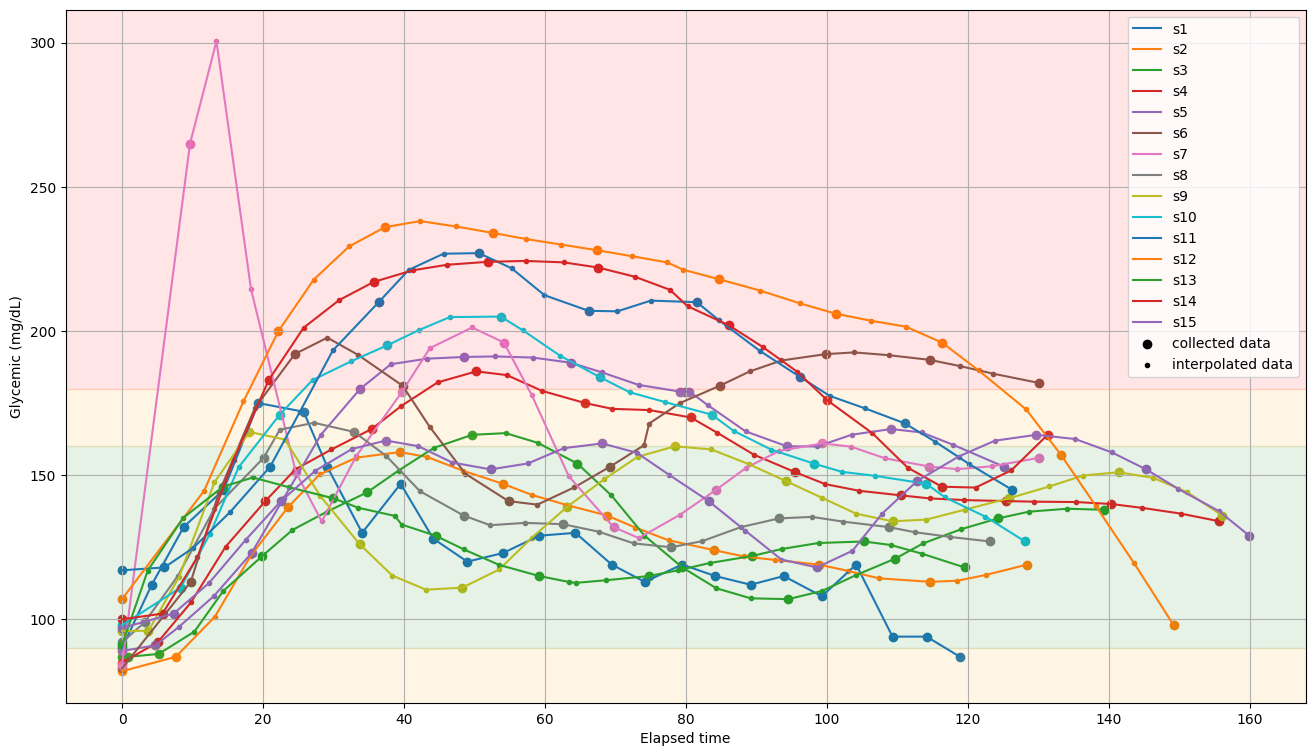

In [23]:
async def load_subject(subject_id:str) -> pd.DataFrame:
    # Index(['subject_id', 'header', 'file_version', 'name', 'creator',
    #        'description', 'created', 'integration_time', 'laser_power',
    #        'average_number', 'scan_mode', 'scan_interval', 'device_model',
    #        'pixel_num', 'device_sn', 'pretreat', 'pixel', 'raman_shift', 'raw',
    #        'dark', 'dark_subtracted', 'baseline_subtracted', 'prick_time',
    #        'glucose_target', 'is_interpolated', 'glucose_predict', 'id',
    #        'elapsed_seconds'],
    #       dtype='object')
    samples:list[OptoFile] = await OptoFile.fetch_all(subject_id=subject_id)
    assert len(samples) > 0
    df = pd.DataFrame([sample.model_dump() for sample in samples])
    df = df[['subject_id', 'created', 'prick_time', 'glucose_target', 'is_interpolated', 'raman_shift', 'raw', 'dark', 'dark_subtracted', 'baseline_subtracted']]
    df['elapsed_seconds'] = [diff.total_seconds() for diff in df.created - df.iloc[0].created]
    df['glucose_interpolated'] = df.glucose_target.interpolate(method='polynomial', order=2)
    # df_w_value = df[df.glucose_target.isnull() == False]
    # Interpolate missing glucose_target values using Cubic Spline
    # cs = CubicSpline(df_w_value['elapsed_seconds'], df_w_value['glucose_target'], bc_type="natural")
    # print(df.glucose_target.interpolate(method='polynomial', order=2) - cs(df['elapsed_seconds']))
    # df['glucose_interpolated'] = cs(df['elapsed_seconds'])
    # print(f"Loaded subject {subject_id} with {len(df)} samples, of which {len(df_w_value)} have glucose_target values.")
    return df

dataset = [df for df in [await load_subject(subject_id=subject_id) for subject_id in subjects]]

fig, ax = plt.subplots(figsize=(16,9))
color_list = list(colors.TABLEAU_COLORS.values())

count = 0
for index, df in enumerate(dataset):
    elapsed_seconds = df['elapsed_seconds'] / 60.0  # Convert to minutes
    glucoses = df['glucose_interpolated']
    ax.scatter(elapsed_seconds, df.glucose_interpolated, c=color_list[index % len(color_list)], marker='.')
    ax.scatter(elapsed_seconds, df.glucose_target,       c=color_list[index % len(color_list)])
    ax.plot(elapsed_seconds   , df.glucose_interpolated, color=color_list[index % len(color_list)], label=df['subject_id'].iloc[0],)
    # plt.plot(elapsed_seconds, glucoses, marker='o', label=df['subject_id'].iloc[0])



    # if(count >= 1):
    #     break
    count += 1

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.scatter(0,0, marker='o', label='collected data', c='black')
ax.scatter(0,0, marker='.', label='interpolated data', c='black')
# ax.set_title("A result of OGTT of 8 participants with polynomial interpolation")
ax.set_xlabel("Elapsed time")
ax.set_ylabel("Glycemic (mg/dL)")
# axisx_format = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,350, color='red', alpha=0.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.grid()
plt.show()

In [26]:
dataset = pd.concat(dataset, ignore_index=True)
dataset

,subject_id,created,prick_time,glucose_target,is_interpolated,raman_shift,raw,dark,dark_subtracted,baseline_subtracted,elapsed_seconds,glucose_interpolated
0,s1,2025-09-25 08:16:44,2025-09-25 08:15:00,90.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43066.4, 43066.4, 43066.4, 43066.4, 43066.4, ...","[27174.8, 27174.8, 27174.8, 27174.8, 27174.8, ...","[15891.6, 15891.6, 15891.6, 15891.6, 15891.6, ...","[389.1032, 393.2731, 397.6122, 402.1241, 406.8...",0.0,90.000000
1,s1,2025-09-25 08:20:57,2025-09-25 08:20:00,112.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43331.2, 43331.2, 43331.2, 43331.2, 43331.2, ...","[27289.8, 27289.8, 27289.8, 27289.8, 27289.8, ...","[16041.4, 16041.4, 16041.4, 16041.4, 16041.4, ...","[379.6331, 383.5506, 387.6291, 391.8719, 396.2...",253.0,112.000000
2,s1,2025-09-25 08:25:29,2025-09-25 08:25:00,132.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43996.0, 43996.0, 43996.0, 43996.0, 43996.0, ...","[27394.8, 27394.8, 27394.8, 27394.8, 27394.8, ...","[16601.2, 16601.2, 16601.2, 16601.2, 16601.2, ...","[263.6184, 267.2868, 271.1085, 275.0872, 279.2...",525.0,132.000000
3,s1,2025-09-25 08:31:10,2025-09-25 08:30:00,145.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43745.2, 43745.2, 43745.2, 43745.2, 43745.2, ...","[27242.8, 27242.8, 27242.8, 27242.8, 27242.8, ...","[16502.4, 16502.4, 16502.4, 16502.4, 16502.4, ...","[296.3765, 300.6178, 305.0327, 309.6249, 314.3...",866.0,145.000000
4,s1,2025-09-25 08:36:05,2025-09-25 08:35:00,175.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43416.6, 43416.6, 43416.6, 43416.6, 43416.6, ...","[27198.2, 27198.2, 27198.2, 27198.2, 27198.2, ...","[16218.4, 16218.4, 16218.4, 16218.4, 16218.4, ...","[222.8331, 226.6198, 230.5636, 234.668, 238.93...",1161.0,175.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
414,s15,2025-10-16 04:20:51,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57887.2, 57887.2, 57887.2, 57887.2, 57887.2, ...","[43034.4, 43034.4, 43034.4, 43034.4, 43034.4, ...","[14852.8, 14852.8, 14852.8, 14852.8, 14852.8, ...","[1766.0912, 1771.5049, 1777.1179, 1788.8797, 1...",8427.0,157.877167
415,s15,2025-10-16 04:25:42,2025-10-16 04:25:00,152.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57870.4, 57870.4, 57870.4, 57870.4, 57870.4, ...","[42997.2, 42997.2, 42997.2, 42997.2, 42997.2, ...","[14873.2, 14873.2, 14873.2, 14873.2, 14873.2, ...","[1638.3457, 1643.592, 1649.0323, 1660.4171, 16...",8718.0,152.000000
416,s15,2025-10-16 04:30:16,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57727.0, 57727.0, 57727.0, 57727.0, 57727.0, ...","[42833.8, 42833.8, 42833.8, 42833.8, 42833.8, ...","[14893.2, 14893.2, 14893.2, 14893.2, 14893.2, ...","[1801.2728, 1806.8465, 1812.625, 1824.5434, 18...",8992.0,145.228083
417,s15,2025-10-16 04:36:00,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57568.0, 57568.0, 57568.0, 57568.0, 57568.0, ...","[42701.6, 42701.6, 42701.6, 42701.6, 42701.6, ...","[14866.4, 14866.4, 14866.4, 14866.4, 14866.4, ...","[1681.7005, 1687.177, 1692.855, 1705.2502, 171...",9336.0,137.561416


<Axes: xlabel='glucose_interpolated', ylabel='Count'>

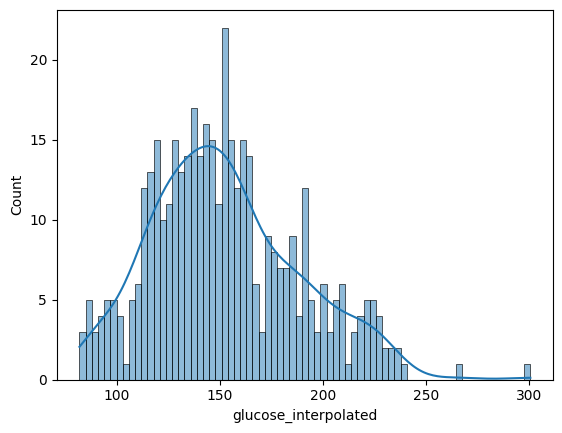

In [31]:
sns.histplot(data=dataset.glucose_interpolated, binwidth=3, kde=True)

## 3. Raman Spectrum

((419, 801), (419,))

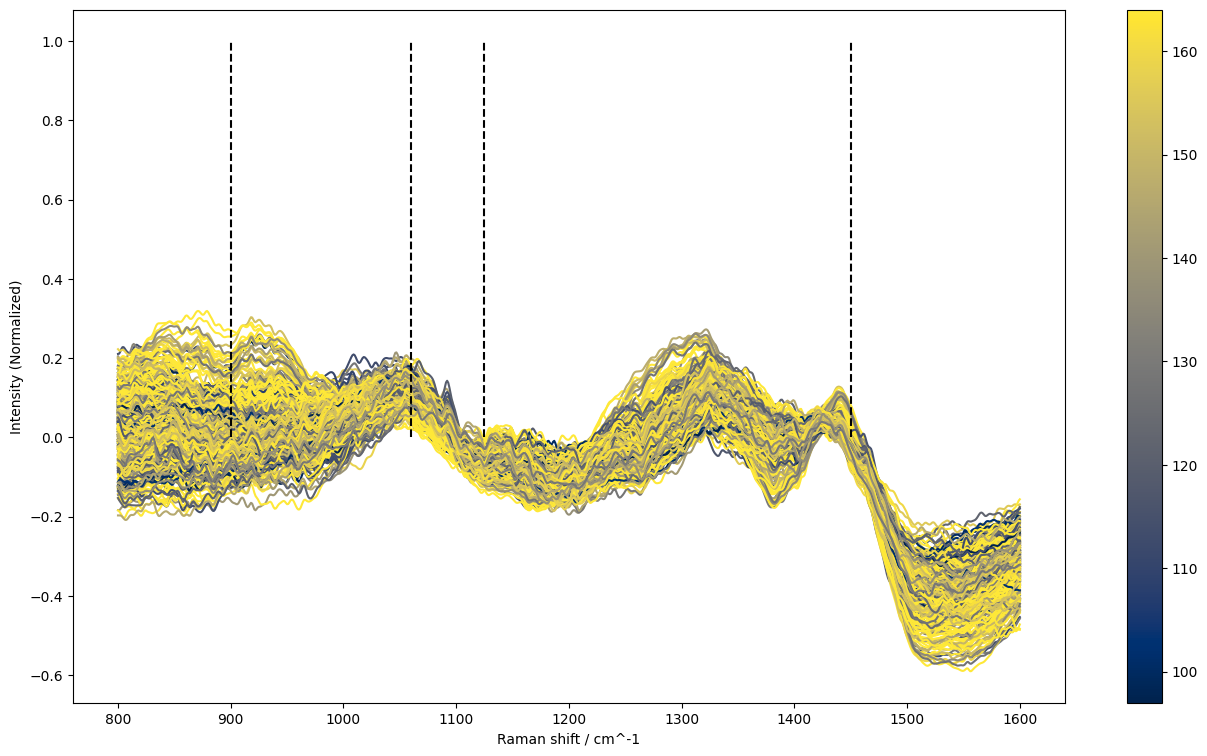

In [95]:
from matplotlib import colormaps, cm
from rampy import baseline as rbaseline
cNorm = colors.Normalize(vmin=min(glucoses), vmax=max(glucoses))
cMap = cm.ScalarMappable(norm=cNorm, cmap=colormaps['cividis'])
colormaps['cividis']
fig,ax = plt.subplots(figsize=(16,9))

color = cMap.to_rgba(dataset.glucose_interpolated)
X = []
y = []
for row in dataset.itertuples():
    sample = Sample(
        x=np.array(row.raman_shift),
        y=np.array(row.baseline_subtracted),
        interpolate=False,
        verbose=True
    )
    sample.despike(window_length=10,threshold=5)
    sample.interpolate(step=1)
    sample.extract_range(low=750, high=1650)
    sample.normalized(method='minmax')
    sample.smoothing(window_length=60, polyorder=1)
    sample.extract_range(low=800, high=1600)
    signal_y, by = rbaseline(sample.x, sample.y, roi=[[905, 915],[1050, 1070],[1100, 1150],[1400,1460]])
    # f835  = sample.at(np.arange(830, 850)).mean()
    # f910  = sample.at(np.arange(905, 950)).mean()
    # f1100 = sample.at(np.arange(1105, 1120)).mean()
    # f1150 = sample.at(np.arange(1160, 1180)).mean()
    # f1210 = sample.at(np.arange(1210, 1230)).mean()
    # f1270 = sample.at(np.arange(1270, 1300)).mean()
    # f1330 = sample.at(np.arange(1335, 1340)).mean()
    # f1450 = sample.at(np.arange(1419, 1455)).mean()
    # f1530 = sample.at(np.arange(1530, 1570)).mean()
    # f1125 = sample.at(np.arange(1120, 1130)).mean()
    # print(f1450)
    # f911  = sample.at(np.arange(905, 915)).mean()
    # f1060 = sample.at(np.arange(1050, 1070)).mean()
    # f1125 = sample.at(np.arange(1125, 1170)).mean()
    f1450 = sample.at(np.arange(1440, 1460)).mean()
    # X.append(np.array([f835,f910,f1100,f1150,f1210,f1270,f1330,f1450,f1530]))
    # X.append(np.hstack([f835,f910,f1100,f1150,f1210,f1270,f1330,f1450,f1530]))
    # X.append(np.array([f911/f1450, f1060/f1450, f1125/f1450]))
    X.append(signal_y.reshape(-1))
    y.append(row.glucose_interpolated)
    # sample.plot()
    color = cMap.to_rgba(row.glucose_interpolated)
    ax.plot(sample.x,signal_y, c=color)
    # y.append(row.glucose_target)
    
fig.colorbar(cMap, ax=ax)
ax.set_xlabel('Raman shift / cm^-1')
ax.set_ylabel('Intensity (Normalized)')
plt.vlines(ymin=0, ymax=1, x=[900, 1060, 1125, 1450], color='black', linestyle='--')
X = np.array(X)
y = np.array(y)
# X = X[y > 0]
# y = y[y > 0]
X.shape, y.shape

<Axes: >

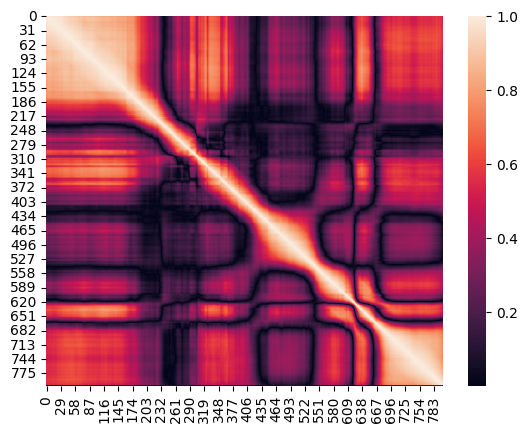

In [100]:
import seaborn as sns
cor = abs(np.corrcoef(np.hstack([X,y.reshape(-1,1)]).T))
sns.heatmap(cor, annot=False)

In [101]:
a = abs(cor[:,-1])
print(a[a.argsort()[::-1]])
print(a.argsort()[::-1][:150] + 800)
print(sorted(a.argsort()[::-1][:150] + 800))

# , np.arange(800,1600))


[1.00000000e+00 1.55915164e-01 1.55624242e-01 1.54503174e-01
 1.53945292e-01 1.52948197e-01 1.51773165e-01 1.50793345e-01
 1.50753236e-01 1.50584044e-01 1.49994279e-01 1.49586335e-01
 1.48810200e-01 1.48528268e-01 1.48248908e-01 1.48159352e-01
 1.48094120e-01 1.47573859e-01 1.47194341e-01 1.46963565e-01
 1.46837732e-01 1.46784260e-01 1.45951820e-01 1.45800513e-01
 1.45698179e-01 1.45517796e-01 1.45249662e-01 1.45229869e-01
 1.45077862e-01 1.45073249e-01 1.45002158e-01 1.44734574e-01
 1.44352845e-01 1.44236989e-01 1.44078255e-01 1.43666399e-01
 1.43655061e-01 1.43456931e-01 1.43430397e-01 1.43310217e-01
 1.43305372e-01 1.42855626e-01 1.42602546e-01 1.42388481e-01
 1.42276102e-01 1.41358206e-01 1.41291846e-01 1.40885597e-01
 1.40851075e-01 1.40604389e-01 1.40494010e-01 1.40321983e-01
 1.40253544e-01 1.39599073e-01 1.39189890e-01 1.38871221e-01
 1.38787504e-01 1.38677373e-01 1.38661209e-01 1.38636086e-01
 1.36875286e-01 1.36578390e-01 1.36364612e-01 1.36119545e-01
 1.36100157e-01 1.355538

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

def train(modelcls, X ,y):
    split = RepeatedKFold(n_splits=5, n_repeats=4, random_state=24)
    best_model = None
    best_pca = None
    best_error = np.inf
    count = 0
    errors = []
    for train, test in split.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        pca = PCA(n_components=25)
        X_train = pca.fit_transform(X_train)
        # Train
        model = None
        if(modelcls == 'mlp'):
            model = MLPRegressor(solver='adam', learning_rate='adaptive', max_iter=100000, hidden_layer_sizes=100, activation='identity')
        else:
            model = modelcls()
        model = model.fit(X_train,y_train.reshape(-1))
        # Test
        X_test = pca.transform(X_test)
        y_hat = model.predict(X_test)
        error = mean_squared_error(y_pred=y_hat,y_true=y_test)
        errors.append(error)
        if(best_error > error):
            best_model = model
            best_error = error
            best_pca = pca
        count = count + 1
    return best_model, best_pca, best_error, np.std(errors)


In [103]:
models = [LinearRegression,
            RandomForestRegressor,
            GradientBoostingRegressor,
            AdaBoostRegressor,
            'mlp']
best_models = []
best_pcas = []
best_errors = []
stds = []
for model in models:
    best_model, best_pca, best_error, std = train(model, X, y)
    print(best_error)
    best_models.append(best_model)
    best_pcas.append(best_pca)
    best_errors.append(best_error)
    stds.append(std)

883.4456884693271
834.6994890211741
1012.7297700401874
887.6451156985746
881.1130989265426


In [64]:
model_names = ['LinearRegression','RandomForestRegressor','GradientBoostingRegressor',"AdaBoostRegressor",'MLPRegressor']
for model_name, best_error, best_model, std in zip(model_names, best_errors, best_models, stds):
    print(model_name, best_error, std, sep='\t')

LinearRegression	855.2798413671331	250.67208598243832
RandomForestRegressor	803.6473395590422	258.14236948796173
GradientBoostingRegressor	963.2806853681363	277.30265648643024
AdaBoostRegressor	827.8736422737098	261.96185875929
MLPRegressor	854.933302876256	252.08415547574924


(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)


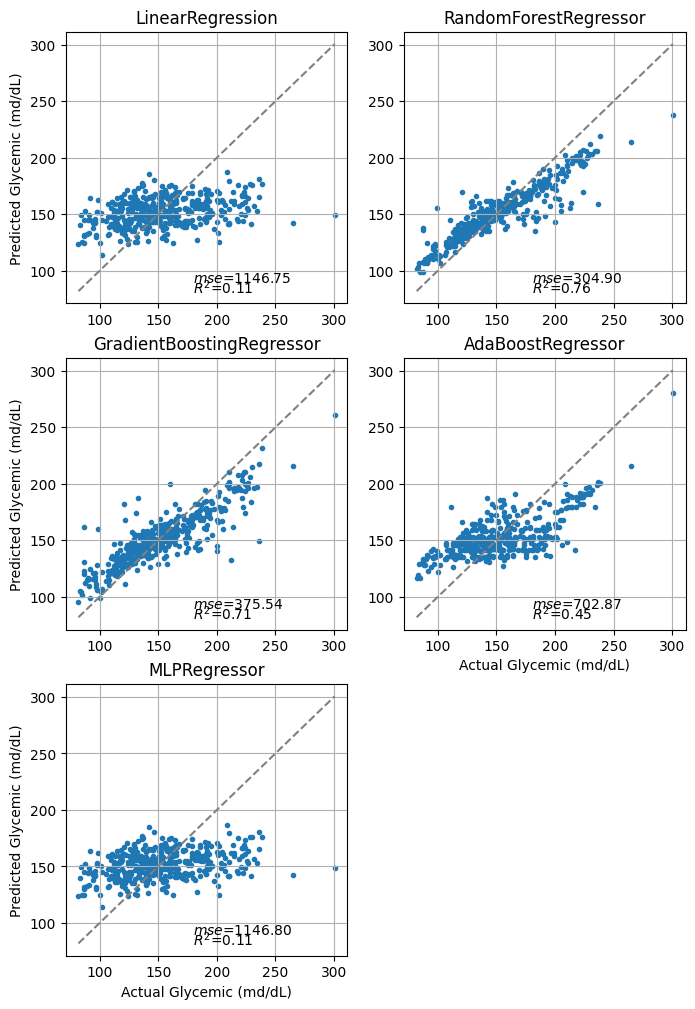

In [66]:
from itertools import product
fig,ax = plt.subplots(figsize=(8,12), ncols=2, nrows=3)
for idx, (model_name, model, pca, coord) in enumerate(zip(model_names, best_models, best_pcas, product([0,1,2],[0,1]))):
    print(coord)
    # y_hat = model.predict(X)
    y_hat = model.predict(pca.transform(X))
    # y_scale = scaler.transform(y.reshape(-1,1))
    # print(X.shape, y_hat.shape, y_scale.shape)
    mse = np.round(mean_squared_error(y_pred=y_hat,y_true=y),2)
    r2 = np.round(r2_score(y_pred=y_hat,y_true=y),2)
    ax[coord[0]][coord[1]].scatter(x=y, y=y_hat, marker='.')
    # ax.scatter(x=y[groups == 1], y=y_hat[groups == 1], color='blue', label='old tube')
    # ax.scatter(x=y[groups == 2], y=y_hat[groups == 2], color='red', label='new tube')
    

    min_xy = min(min(y), min(y_hat))
    max_xy = max(max(y), max(y_hat))
    ax[coord[0]][coord[1]].plot([min_xy, max_xy], [min_xy, max_xy], linestyle='--', color='grey')
    # if(model_name == 'LinearRegression'):
    #     ax[coord[0]][coord[1]].text(180,0,s=f'$R^2$={r2:.2f}')
    #     ax[coord[0]][coord[1]].text(180,20,s=f'$mse$={mse:.2f}')
    # else:
    ax[coord[0]][coord[1]].text(180,80,s=f'$R^2$={r2:.2f}')
    ax[coord[0]][coord[1]].text(180,90,s=f'$mse$={mse:.2f}')
    if(coord[0] == 2 or (coord[1] == 1 and coord[0] == 1)):
        ax[coord[0]][coord[1]].set_xlabel('Actual Glycemic (md/dL)')
    if(coord[1] == 0):
        ax[coord[0]][coord[1]].set_ylabel('Predicted Glycemic (md/dL)')
    ax[coord[0]][coord[1]].set_title(model_name)
    # ax.legend()
    ax[coord[0]][coord[1]].grid()
fig.delaxes(ax[2][1])
plt.show()



In [ ]:
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

cv = RepeatedKFold(n_splits=5, n_repeats=4, random_state=1)
best_model = None
best_score = -float('inf')
best_PCA = None
for train_index, test_index in cv.split(X,y):
    print("train_szie:", len(train_index), "test_size:", len(test_index))
    X_train = X[train_index]
    y_train = y[train_index]
    X_test  = X[test_index]
    y_test  = y[test_index]


    # pca = PCA(n_components=25)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)
    
    model = RandomForestRegressor()

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    # print(y_hat)
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_PCA = pca
    print(f'Mean Squared Error: {mse}', f'R^2 Score: {r2}')

train_szie: 288 test_size: 72
Mean Squared Error: 962.682994787767 R^2 Score: -0.01142445857609431
train_szie: 288 test_size: 72
Mean Squared Error: 872.0717730399617 R^2 Score: 0.11475167780452877
train_szie: 288 test_size: 72
Mean Squared Error: 1628.6217934450426 R^2 Score: -0.018103134716185965
train_szie: 288 test_size: 72
Mean Squared Error: 1166.246756935946 R^2 Score: 0.11200376382068522
train_szie: 288 test_size: 72
Mean Squared Error: 1176.6985674887994 R^2 Score: 0.14802763832152466
train_szie: 288 test_size: 72
Mean Squared Error: 1088.836690885995 R^2 Score: 0.20958858327920749
train_szie: 288 test_size: 72
Mean Squared Error: 1251.7888684803538 R^2 Score: 0.03060265483543234
train_szie: 288 test_size: 72
Mean Squared Error: 1195.3133212596576 R^2 Score: -0.0804082632567773
train_szie: 288 test_size: 72
Mean Squared Error: 1498.7371295855878 R^2 Score: -0.0726344941946453
train_szie: 288 test_size: 72
Mean Squared Error: 920.9568552577764 R^2 Score: 0.08190010966896599
tra

In [91]:
# y_hat = best_model.predict(best_PCA.transform(X))
y_hat = best_model.predict(X)
mean_squared_error(y, y_hat), r2_score(y, y_hat)

(358.42160437546875, 0.7161986902318263)